In [ ]:
#!pip install tensorflow==2.5.1
#!pip install opencv-python
#!pip install clustimage

In [26]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, UpSampling2D, Input, ZeroPadding2D, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
#import tensorflow_probability as tfp

from scipy import stats
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import mse, binary_crossentropy,mean_absolute_error ,huber
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import unit_norm, max_norm
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import StratifiedKFold, train_test_split
#import nibabel as nib
import scipy as sp
import scipy.ndimage
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

import cv2

from features_images import image_feats  

2.5.1


# LOADING THE DATASET

In [2]:
hf=h5py.File("../data/img_p+Fe_MST+SST.hdf5", 'r')
hf.keys()

<KeysViewHDF5 ['MST', 'SST']>

# SST (48X48) and MST(112X112) IMAGES

In [3]:
data_MST = hf['MST']
data_SST = hf['SST']
data_MST.keys()

<KeysViewHDF5 ['ENERGY', 'LABEL', 'XMAX', 'X_MONO', 'X_STEREO', 'Y']>

# MONO (1 TELESCOPE) and STEREO(>1 TELESCOPES)

In [4]:
imgs_MST_MONO = data_MST['X_MONO']
imgs_MST_STER = data_MST['X_STEREO']
imgs_SST_MONO = data_SST['X_MONO']
imgs_SST_STER = data_SST['X_STEREO']


# separated by species
imgs_MST_MONO_Fe = imgs_MST_MONO[0]
imgs_MST_MONO_p  = imgs_MST_MONO[1]
imgs_MST_STER_Fe = imgs_MST_STER[0]
imgs_MST_STER_p  = imgs_MST_STER[1]

imgs_SST_MONO_Fe = imgs_SST_MONO[0]
imgs_SST_MONO_p  = imgs_SST_MONO[1]
imgs_SST_STER_Fe = imgs_SST_STER[0]
imgs_SST_STER_p  = imgs_SST_STER[1]

#p+Fe images
imgs_MST_MONO_Fe_p = np.concatenate((imgs_MST_MONO_Fe, imgs_MST_MONO_p), axis=0)
imgs_MST_STER_Fe_p = np.concatenate((imgs_MST_STER_Fe, imgs_MST_STER_p), axis=0)

imgs_SST_MONO_Fe_p = np.concatenate((imgs_SST_MONO_Fe, imgs_SST_MONO_p), axis=0)
imgs_SST_STER_Fe_p = np.concatenate((imgs_SST_STER_Fe, imgs_SST_STER_p), axis=0)

In [5]:
def normalize_img(data):
    x_min = np.min(data.flatten())
    x_max = np.max(data.flatten())
    delta = x_max-x_min
    return (data-x_min)/delta

# DATA AUGMENTATION

In [123]:
def augment_by_transformation(data,age,isVar,n):
    augment_scale = 1

    if n <= data.shape[0]:
        return data, age
    else:
        raw_n = data.shape[0]
        m = n - raw_n
        for i in range(0,m):
            new_data = np.zeros((1,data.shape[1],data.shape[2],1))
            idx = np.random.randint(0,raw_n)
            new_age = age[idx]
            new_data[0] = data[idx].copy()
            new_data[0,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,0],np.random.uniform(-1,1),axes=(1,0),reshape=False)
            new_data[0,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,0],np.random.uniform(-1,1),axes=(0,1),reshape=False)
            new_data[0,:,:,0] = sp.ndimage.shift(new_data[0,:,:,0],np.random.uniform(-1,1))
            data = np.concatenate((data, new_data), axis=0)
            if isVar:
                age = np.vstack((age, new_age))
            else:
                age = np.append(age, new_age)
                

    return data, age

def augment_by_noise(data,n,sigma):
    if n <= data.shape[0]:
        return data
    else:
        m = n - data.shape[0]
        for i in range(0,m):
            new_data = np.zeros((1,data.shape[1],data.shape[2],1))
            new_data[0] = data[np.random.randint(0,data.shape[0])]
            noise = np.clip(np.random.normal(0,sigma,(data.shape[1],data.shape[2],1)),-3*sigma,3*sigma)
            new_data[0] += noise
            data = np.concatenate((data, new_data), axis=0)
    return data
        
        
def augment_by_flip(data):
    data_flip = np.flip(data,1)
    data = np.concatenate((data, data_flip), axis=0)
    return data

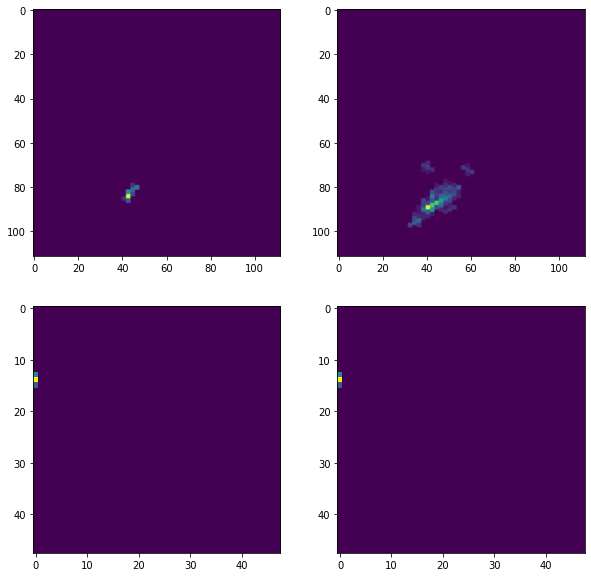

In [7]:
nx = 0
imag1 = imgs_MST_MONO_p
imag2 = imgs_MST_STER_p
imag3 = imgs_SST_MONO_p
imag4 = imgs_SST_STER_p

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag3[nx]))
# show the plot
plt.show()

In [8]:
imagens = image_feats(imgs_MST_MONO_p)
num_p = imagens.count_pixels()
numcl_p = imagens.num_cluster()
max_p = imagens.max_pixels()
mean_p = imagens.mean_pixels()
std_p = imagens.std_pixels()

imagens = image_feats(imgs_MST_MONO_Fe)
num_Fe = imagens.count_pixels()
numcl_Fe = imagens.num_cluster()
max_Fe = imagens.max_pixels()
mean_Fe = imagens.mean_pixels()
std_Fe = imagens.std_pixels()

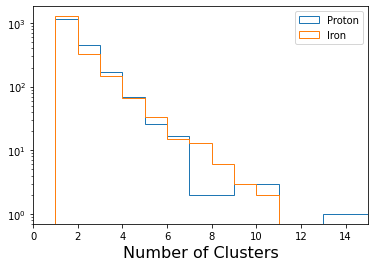

In [20]:
nbins = np.arange(0,51,1)
plt.hist(numcl_p,bins=nbins,histtype='step',label='Proton')
plt.hist(numcl_Fe,bins=nbins,histtype='step',label='Iron')
plt.xlim([0,15])
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('Number of Clusters',size=16)
plt.show()

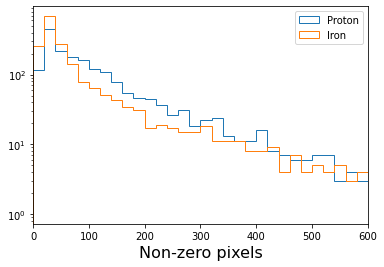

In [10]:
nbins = np.arange(0,1520,20)
plt.hist(num_p,bins=nbins,histtype='step',label='Proton')
plt.hist(num_Fe,bins=nbins,histtype='step',label='Iron')
plt.legend(loc='best')
plt.xlim([0,600])
plt.yscale('log')
plt.xlabel('Non-zero pixels',size=16)
plt.show()

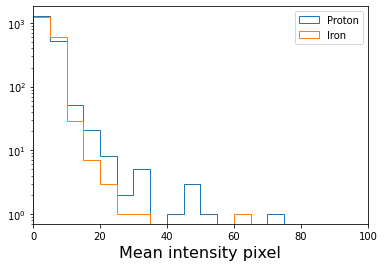

In [13]:
nbins = np.arange(0,505,5)
plt.hist(mean_p,bins=nbins,histtype='step',label='Proton')
plt.hist(mean_Fe,bins=nbins,histtype='step',label='Iron')
plt.legend(loc='best')
plt.xlim([0,100])
plt.yscale('log')
plt.xlabel('Mean intensity pixel',size=16)
plt.show()

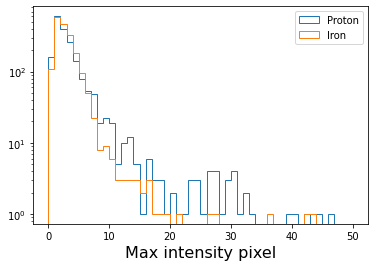

In [19]:
nbins = np.arange(0,51,1)
plt.hist(std_p,bins=nbins,histtype='step',label='Proton')
plt.hist(std_Fe,bins=nbins,histtype='step',label='Iron')
plt.legend(loc='best')
#plt.xlim([0,300])
plt.yscale('log')
plt.xlabel('Max intensity pixel',size=16)
plt.show()

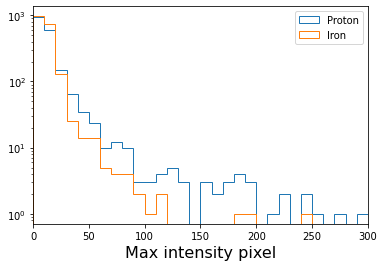

In [14]:
nbins = np.arange(0,2010,10)
plt.hist(max_p,bins=nbins,histtype='step',label='Proton')
plt.hist(max_Fe,bins=nbins,histtype='step',label='Iron')
plt.legend(loc='best')
plt.xlim([0,300])
plt.yscale('log')
plt.xlabel('Max intensity pixel',size=16)
plt.show()

In [25]:
np.vstack((np.vstack((max_p,max_Fe)),mean_p)).reshape((1900,3))

array([[ 10.2213707 ,   6.54524899,  10.80866146],
       [ 12.80746841, 177.27896118,   8.70680237],
       [ 15.26240635,   7.68272638,  72.3416214 ],
       ...,
       [  6.43684988,   2.89181327,   7.61956685],
       [  3.57239643,   8.03541224,   3.82373781],
       [  3.45386027,   5.07465046,   3.23661135]])

In [31]:
df = pd.DataFrame()

In [32]:
df['non-zero'] = num_Fe
df['num-clusters'] = numcl_Fe
df['max'] = max_Fe
df['mean'] = mean_Fe
df['std'] = std_Fe

In [33]:
df.head(10)

,non-zero,num-clusters,max,mean,std
0,1044,2,41.304054,7.753409,7.861331
1,16,1,4.220771,3.334475,0.734738
2,16,1,34.951233,12.136568,13.222143
3,20,1,7.281611,4.647685,1.618677
4,56,1,14.537166,6.382393,4.758441
5,20,1,9.352634,3.823731,2.825198
6,20,1,6.388031,3.160892,1.768900
7,16,2,10.099965,5.564115,2.825832
8,20,1,9.098149,4.812772,2.286782
9,24,1,6.047159,3.098466,1.452641


In [34]:
df.to_csv('../data/image_features_iron.csv')

In [37]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

/tmp/ipykernel_24046/3314849639.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,non-zero,num-clusters,max,mean,std
non-zero,1.000,0.479,0.664,0.492,0.600
num-clusters,0.479,1.000,0.075,0.037,0.061
max,0.664,0.075,1.000,0.754,0.928
mean,0.492,0.037,0.754,1.000,0.897
std,0.600,0.061,0.928,0.897,1.000


In [38]:
import seaborn as sns

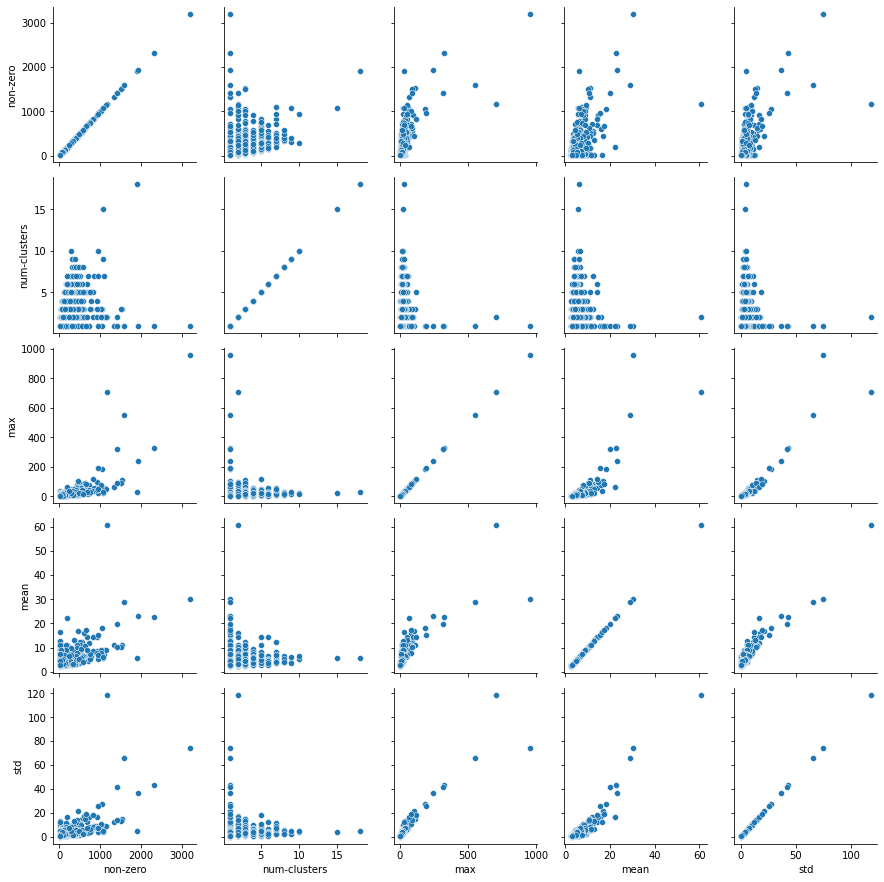

In [39]:
#iris = sns.load_dataset("iris")
g = sns.PairGrid(df)
g.map(sns.scatterplot)

In [ ]:
nx = 10
imag1 = imgs_MST_MONO_Fe
imag2 = imgs_MST_STER_Fe
imag3 = imgs_SST_MONO_Fe
imag4 = imgs_SST_STER_Fe

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag3[nx]))
# show the plot
plt.show()

In [ ]:
np.count_nonzero(imag2[nx])

# LABELS
# iron = 1st component / proton = 2nd 

In [ ]:
#LABEL_MST_MONO = data_IMGs_MST['LABEL']
#LABEL_MST_STER = data_IMGs_MST['LABEL']
#LABEL_MST_STER

# ENERGY, XMAX, Y

In [40]:
# XMAX by species
XMAX_MST_Fe = data_MST['XMAX'][0]
XMAX_MST_p  = data_MST['XMAX'][1]

XMAX_SST_Fe = data_SST['XMAX'][0]
XMAX_SST_p  = data_SST['XMAX'][1]

#p+Fe
XMAX_MST = np.concatenate((XMAX_MST_Fe,XMAX_MST_p), axis=0)
XMAX_SST = np.concatenate((XMAX_SST_Fe,XMAX_SST_p), axis=0)

# test
E_SST_Fe = data_SST['ENERGY'][0]

In [ ]:
plt.hist2d(E_SST_Fe,XMAX_SST_Fe,bins=100)
plt.show()

In [ ]:
plt.scatter(E_SST_Fe,XMAX_SST_Fe,s=2)
plt.show()

In [ ]:
nbins= np.arange(100,900,20)
plt.hist(XMAX_SST_Fe,bins=nbins,histtype='step',label='Fe')
plt.hist(XMAX_SST_p,bins=nbins,histtype='step',label='p')
plt.legend(loc='best')
plt.xlabel(r'$X_{max}$',size=14)
plt.title('SST',size=14)
plt.yscale('log')
#plt.savefig('../figures/XMAX_Fe_P_SST.pdf')
plt.show()

In [ ]:
nbins= np.arange(100,900,20)
plt.hist(XMAX_MST_Fe,bins=nbins,histtype='step',label='Fe')
plt.hist(XMAX_MST_p,bins=nbins,histtype='step',label='p')
plt.legend(loc='best')
plt.xlabel(r'$X_{max}$',size=14)
plt.title('MST',size=14)
plt.yscale('log')
#plt.savefig('../figures/XMAX_Fe_P_MST.pdf')
plt.show()

# VARIATIONAL AUTO-ENCODER MODEL

In [41]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def Nsampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# ENCODER

In [152]:
def encodeNN(input_image,latent_dim,isVar,input_cVar,dp,n_ft,n_conv):
    
    x0 = Conv2D(n_ft, activation='relu', kernel_size=(3, 3),padding='same')(input_image)
    x0 = MaxPooling2D(pool_size=(2, 2))(x0)
    
    for k in range(n_conv):
        fac = int(2*(k+1))
        x0 = Conv2D(int(n_ft/2), activation='relu', kernel_size=(3, 3),padding='same')(x0)
        x0 = MaxPooling2D(pool_size=(2, 2))(x0)

    x1 = Flatten()(x0)
    if isVar:
        # Concatenate Energy
        #input_cVar = Input(shape=(5,), name='cVar')
        xc = Dense(5,)(input_cVar)
        x1 = Concatenate()([x1, xc])
        
    x1 = Dropout(dp)(x1)
    x1 = Dense(int(latent_dim*2), activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(x1)
    xo = Dense(int(latent_dim*4), activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(x1)
    
    return xo

# DECODER

In [45]:
def decodeNN(latent_input,orig_dim_img,latent_dim,n_ft,L2_reg,reco_loss):
    
    patch_x,patch_y = orig_dim_img

    # build decoder model
    y = Dense(latent_dim*2, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(latent_input)
    y = Dense(latent_dim*4, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(y)
    y = Dense(int(patch_x/8*patch_y/8*n_ft*4), activation='relu',kernel_regularizer=regularizers.l2(L2_reg))(y)
    y = Reshape((int(patch_x/8),int(patch_y/8),n_ft*4))(y)
    
    y = Conv2D(n_ft*4, kernel_size=(3, 3),padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = UpSampling2D((2,2))(y)

    y = Conv2D(n_ft*2, kernel_size=(3, 3),padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = UpSampling2D((2,2))(y)

    y = Conv2D(n_ft, kernel_size=(3, 3),padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = UpSampling2D((2,2))(y)

    yo = Conv2D(1, kernel_size=(3, 3),padding='same')(y)
    
    if reco_loss=='binary':
        yo = Activation('sigmoid')(yo)
    else:
        yo = yo
        
    return yo

# LATENT SPACE

In [47]:
# q(z|x) neural net
def qzx(xo,latent_dim):
    
    z_mean_o = Dense(latent_dim*2, activation='tanh', name='z_mean_o')(xo)
    z_mean   = Dense(latent_dim, activation = 'linear', name='z_mean')(z_mean_o)
    
    z_log_var_o = Dense(latent_dim*2, activation='tanh', name='z_log_var_o')(xo)
    z_log_var   = Dense(latent_dim, name='z_log_var')(z_log_var_o)
    
    return z_mean, z_log_var

# LATENT GENERATOR

In [48]:
# latent generator (simplified)
# p(z|c) : c --> latent_dim
def latent_generator(gen_input,latent_dim):
    
    inter_z_1 = Dense(int(latent_dim/4), activation='tanh', kernel_constraint=unit_norm(), name='inter_z_1')(gen_input)
    #inter_z_2 = Dense(int(latent_dim/2), activation='tanh', kernel_constraint=unit_norm(), name='inter_z_2')(inter_z_1)
    pz_mean = Dense(latent_dim, name='pz_mean', kernel_constraint=unit_norm())(inter_z_1)
    #pz_mean = Dense(latent_dim, name='pz_mean', kernel_constraint=unit_norm())(generator_input)
    pz_log_var = Dense(1, name='pz_log_var',kernel_constraint=max_norm(0))(gen_input)
    
    return pz_mean, pz_log_var

# PROBABILISTIC REGRESSORS

In [49]:
# Mean
def Mregressor(xo,orig_dim_r,latent_dim):
    
    x = Dense(latent_dim*2, activation='tanh', name='r_mean_1')(xo)
    #x = Dropout(0.1)(x)
    x = Dense(latent_dim, activation='tanh', name='r_mean_2')(x)
    r_mean   = Dense(orig_dim_r, name='r_mean')(x)
    
    return r_mean

# Log Variance
def Vregressor(xo,orig_dim_r,latent_dim):
    
    x = Dense(latent_dim*2, activation='tanh', name='r_log_var_1')(xo)
    x = Dense(latent_dim, activation='tanh', name='r_log_var_2')(x)
    r_log_var   = Dense(orig_dim_r, name='r_log_var')(x)
    
    return r_log_var

In [147]:
## Build VAE-Regression Model
def VAE_Reg(orig_dim_img,dp,L2_reg,latent_dim,reco_loss,isVar,dim_cVar,n_ft,n_conv):
    
    # VAE model = encoder + decoder
    patch_x,patch_y = orig_dim_img
    input_r = Input(shape=(1, ), name='ground_truth')
    input_image = Input(shape=(patch_x,patch_y,1), name='input_image')
    
    # calling encoder model    
    input_cVar = Input(shape=(dim_cVar,), name='cVar')
    xin = encodeNN(input_image,latent_dim,isVar,input_cVar,dp,n_ft,n_conv)

    # q(z|x)
    z_mean, z_log_var =  qzx(xin,latent_dim)
    
    # posterior on Y; probablistic regressor
    r_mean = Mregressor(xin,orig_dim_r,latent_dim)
    r_log_var = Vregressor(xin,orig_dim_r,latent_dim)

    # use reparameterization trick to push the sampling out as input
    z = Lambda(Nsampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    r = Lambda(Nsampling, output_shape=(1,), name='r')([r_mean, r_log_var])
    # instantiate encoder model
    encoder = Model([input_image,input_r,input_cVar], [z_mean, z_log_var, z, r_mean, r_log_var, r], name='encoder')
    encoder.summary()
    
    # build generator model
    generator_input = Input(shape=(1,), name='generator_input')
    pz_mean, pz_log_var = latent_generator(generator_input,latent_dim)
    # instantiate generator model
    generator = Model(generator_input, [pz_mean,pz_log_var], name='generator')
    generator.summary()    
    
    
    # build decoder model
    latent_input = Input(shape=(latent_dim,), name='z_sampling')
    outputs = decodeNN(latent_input,orig_dim_img,latent_dim,n_ft,L2_reg,reco_loss)

    # instantiate decoder model
    decoder = Model(latent_input, outputs, name='decoder')
    decoder.summary()
    
    # instantiate VAE model
    pz_mean,pz_log_var = generator(encoder([input_image,input_r,input_cVar])[5])
    outputs = decoder(encoder([input_image,input_r,input_cVar])[2])
    vae = Model([input_image,input_r,input_cVar], [outputs, pz_mean,pz_log_var], name='vae_mlp')
    
    #vae.summary()
    return vae, encoder, decoder, generator, outputs, input_image, input_r, z_mean, z_log_var, z, r_mean, r_log_var, r, pz_mean, pz_log_var

In [51]:
##Customize Lost Function of the VAE Model
#models = (encoder, decoder)
def VAELoss(input_image,input_r,outputs,z_mean,z_log_var,z,r_mean,r_log_var,r,pz_mean,pz_log_var,reco_loss):

    if reco_loss=='binary':
        reconstruction_loss = K.mean(binary_crossentropy(input_image,outputs), axis=[1,2])
    elif reco_loss=='mse':
        reconstruction_loss = K.mean(mean_absolute_error(input_image,outputs), axis=[1,2])
    #elif reco_loss=='huber':
    #    reconstruction_loss = lam*K.mean(mean_absolute_error(input_image,outputs), axis=[1,2])+(1-lam)*huber(input_image,outputs,delta=delta)

    kl_loss = 1 + z_log_var - pz_log_var - tf.math.divide(K.square(z_mean-pz_mean),K.exp(pz_log_var)) - tf.math.divide(K.exp(z_log_var),K.exp(pz_log_var))
    #kl_loss = 1 + z_log_var - K.square(z_mean-pz_mean) - K.exp(z_log_var)
    kl_loss = -0.5*K.sum(kl_loss, axis=-1)
    label_loss = tf.math.divide(0.5*K.square(r_mean - input_r), K.exp(r_log_var)) +  0.5 * r_log_var

    vae_loss = K.mean(reconstruction_loss+kl_loss+label_loss)
    
    return vae_loss

In [98]:
# Setting the Hyperparameters
## CNN Parameters 
dp = 0.1
n_ft = 32
n_conv = 4
latent_dim = 24
L2_reg= 0.0
reco_loss = 'binary'
# Learning Rate
lr = 1e-3
# Epochs
epochs = 100
# batch size
batch_size = 64
# augmentatio
augment_size = 3000
# auxiliary variable
isVar = True

# TRAIN/TEST SPLIT

In [54]:
data_images = normalize_img(imgs_SST_STER_Fe)
orig_dim_img = [data_images.shape[1],data_images.shape[2]]

yXmax = np.log(XMAX_SST_Fe)
#yE = np.log(E_SST_Fe)
yE = df.values

orig_dim_r = 1
print(orig_dim_img, orig_dim_r)

fake = np.zeros((data_images.shape[0]))
pred = np.zeros((yXmax.shape))

[48, 48] 1


In [124]:
# Train/Test split
rs = 42
train_data, test_data, train_xmax, test_xmax = train_test_split(data_images,yXmax,test_size=0.2,shuffle=True,random_state=rs)
_, _, train_e, test_e = train_test_split(data_images,yE,test_size=0.2,shuffle=True,random_state=rs)

In [122]:
train_xmax.shape

(1520,)

In [125]:
# augment data
train_data_aug, train_xmax_aug = augment_by_transformation(train_data,train_xmax,False,augment_size)
_, train_e_aug = augment_by_transformation(train_data,train_e,True,augment_size)

In [126]:
print(train_data.shape,train_data_aug.shape)
print(train_xmax_aug.shape,train_e_aug.shape)

(1520, 48, 48, 1) (3000, 48, 48, 1)
(3000,) (3000, 5)


In [61]:
def conv(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [101]:
train_xmax_aug = conv(train_xmax_aug)
input_cVar = conv(train_e_aug)
#train_xmax_aug.shape

In [153]:
## Train the network
#for train_idx, test_idx in skf.split(data_images, fake):
    
    #print(train_idx)
    
#    train_data = data_images[train_idx]
#    train_e = np.log(yE[train_idx])

#    test_data = data_images[test_idx]
#    test_e = np.log(yE[test_idx])

checkpoint_filepath = '../models/xmax_best_weights_SST_STER_Fe.h5' 
model_checkpoint_callback = ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    save_weights_only=True,
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True)

# instantiate the model
vae,encoder,decoder,generator,outputs,input_image,input_r,z_mean,z_log_var,z,r_mean,r_log_var,r,pz_mean,pz_log_var = VAE_Reg(orig_dim_img,dp,L2_reg,
                                                latent_dim,reco_loss,isVar,5,n_ft,n_conv)

# Computing the Loss Function
vae_loss = VAELoss(input_image,input_r,outputs,z_mean,z_log_var,z,r_mean,r_log_var,r,
                   pz_mean,pz_log_var,reco_loss)
vae.add_loss(vae_loss)

######################################
#step = tf.Variable(0, trainable=False)
#schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#    [200, 400, 600, 800], [1.0, 0.5, 0.25, 0.125, 0.0625])
# lr and wd can be a function or a tensor
#lr = 1e-3 #* schedule(step)
#wd = lambda: 1e-2 * schedule(step)
loss_fn = mse
opt = Adam(learning_rate=lr) #'adam'
#opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
reduce_lr = ReduceLROnPlateau(monitor='lr', factor=0.5,
                              patience=25, min_lr=1e-6)



########## Early stopping
stop = EarlyStopping(monitor='val_loss', mode='min', patience=20)

######################################
# Compilation
vae.compile(loss=loss_fn,optimizer=opt, metrics=['mae', 'mse'])
vae.summary()
#vae.save_weights('../models/vae_dnn_weights.hdf5')

history=vae.fit([train_data,train_xmax,input_cVar],
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[model_checkpoint_callback, reduce_lr, stop], #,TensorBoard(log_dir='/tmp/autoencoder')],
                validation_split = 0.25,
                #validation_data=([X_valid, Y_valid]),
                verbose = 1)

vae.save_weights('../models/xmax_vae_weights_SST_STER_Fe-aug.h5')
encoder.save_weights('../models/xmax_encoder_weights_SST_STER_Fe-aug.h5')
generator.save_weights('../models/xmax_generator_weights_SST_STER_Fe-aug.h5')
decoder.save_weights('../models/xmax_decoder_weights_SST_STER_Fe-aug.h5')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 48, 48, 32)   320         input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_85 (MaxPooling2D) (None, 24, 24, 32)   0           conv2d_133[0][0]                 
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 24, 24, 16)   4624        max_pooling2d_85[0][0]           
____________________________________________________________________________________________

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
ground_truth (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cVar (InputLayer)               [(None, 5)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 24), (None,  41072       input_image[0][0]                
                                                                 ground_truth[0][0]         

ValueError: in user code:

    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:850 train_function  *
        return step_function(self, iterator)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:840 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:833 run_step  **
        outputs = model.train_step(data)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:790 train_step
        y_pred = self(x, training=True)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:420 call
        return self._run_internal_graph(
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:420 call
        return self._run_internal_graph(
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/alexandre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_84 is incompatible with the layer: expected axis -1 of input shape to have value 5 but received input with shape (None, 1)


In [80]:
vae.load_weights('../models/xmax_best_weights_SST_STER_Fe.h5')
vae.compile(loss=loss_fn,optimizer=opt)

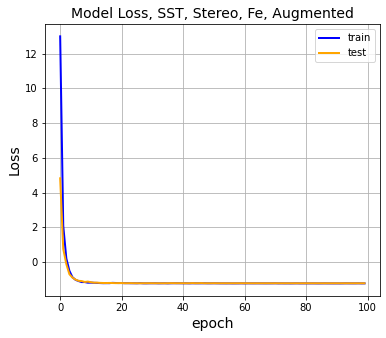

In [81]:
plt.figure(figsize=(6,5))
plt.plot(history.history['loss'], lw=2, color='blue')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.title('Model Loss, SST, Stereo, Fe, Augmented',size=14)
plt.ylabel('Loss',size=14)
plt.xlabel('epoch',size=14)
plt.grid(True)
#plt.yscale('log')
plt.legend(['train','test'], loc='best')
#plt.savefig('../figures/xmax_loss_vae_sst_ster_Fe-aug.pdf')
plt.show()

In [82]:
# testing

pix = []
ypred = np.zeros(len(test_xmax))
for k in range(100):
    [z_mean, z_log_var, z, r_mean, r_log_var, r_vae] = encoder.predict([test_data,test_xmax,test_e],batch_size=batch_size)
    ypred = ypred+r_vae[:,0]
    pix.append([r_vae[100][0]])
    
ypred = ypred/100

#filename = 'prmean_squared_error(test_e,ypred)ediction_'+str(dp)+'_'+str(L2_reg)+'.npy'
#np.save(filename,pred)
MSE_test = mean_squared_error(test_xmax,ypred)
R2_test = r2_score(test_xmax, ypred)
## CC accuracy
print("MSE: ",MSE_test)
print("R2: ",R2_test)

MSE:  0.03060618077385066
R2:  -0.031298838859638245


In [ ]:
#pix

In [ ]:
plt.hist(r_vae[:,0],bins=20,histtype='step')
plt.show()

In [ ]:
len(r_vae)

In [ ]:
def chi2(a,b):
    x2 = (a-b)**2
    return np.sum(x2/a)

In [96]:
nbins = np.arange(120,420,20)
a, _ = np.histogram(np.exp(test_xmax),bins=nbins)
b, _ = np.histogram(np.exp(ypred),bins=nbins)
xpdof = chi2(a,b)/len(a)

NameError: name 'chi2' is not defined

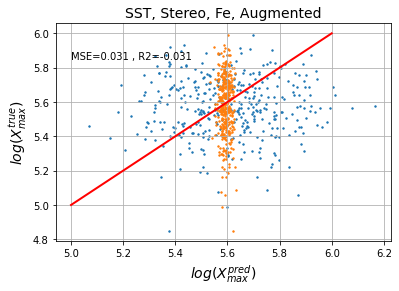

In [83]:
plt.scatter(r_vae[:,0], test_xmax, s=2)
plt.scatter(ypred, test_xmax, s=2)
plt.plot([5,6],[5,6],lw=2,color='red')
#plt.xlim([0,11])
#plt.ylim([0,11])
plt.grid(True)
plt.xlabel(r'$log(X_{max}^{pred})$',size=14)
plt.ylabel(r'$log(X_{max}^{true})$',size=14)
plt.text(5,5.85,"MSE=%.3f , R2=%.3f"%(MSE_test,R2_test))
plt.title('SST, Stereo, Fe, Augmented',size=14)
#plt.savefig('../figures/xmax_true_pred_vae_sst_ster_Fe-aug.pdf')
plt.show()

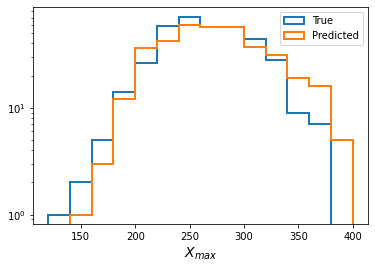

In [97]:
plt.hist(np.exp(test_xmax),bins=nbins,lw=2,histtype='step',label='True')
plt.hist(np.exp(r_vae[:,0]),bins=nbins,lw=2,histtype='step',label='Predicted')
#plt.hist(np.exp(ypred),bins=nbins,lw=2,histtype='step',label='Predicted-mean')
plt.xlabel(r'$X_{max}$',size=14)
plt.legend(loc='best')
plt.yscale('log')
#plt.text(120,50,r"$\chi^2$/dof=%.3f"%(xpdof),size=14)
#plt.savefig('../figures/xmax_vae_sst_ster_Fe-aug.pdf')
plt.show()